## Hate Sense Classification 

In [1]:
# Import necessary libraries
import torch, re
import pandas as pd
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification

from tqdm import tqdm
from difflib import get_close_matches
import torch.nn as nn
import torch.optim as optim

/Users/ozgealacam/Library/CloudStorage/OneDrive-Personal/00_LMU/HateSpeech23_24/lecture_content/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [17]:

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#!pip install openpyxl

In [18]:
train_data_path = '../Project1_HateSenseClassification/TESTannotation_sample_1.xlsx' 
test_data_path = '../Project1_HateSenseClassification/TESTannotation_sample_7.xlsx' 

## here is 50-50 train and test ratio which is not the usual case. 
# 80-20 (train-test) or (80-10-10) (train-validation-test) set options are more reasonable. 
# so you can merge two dataframe, and use sklearn.train_test_split function for better ratio.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html 

Loading the data into Pandas DataFrames

In [19]:
train_df = pd.read_excel(train_data_path, 'data')
test_df = pd.read_excel(test_data_path, 'data')

## Notice that annotations are not gold annotation, collected from only one annotator, so not reliable!

In [20]:
train_df

,id,example,term,pos,sense_id,definition,ANNOTATION,DEFICIENT SENTENCE
0,1466,So I took the gun and went up a piece into the...,fellow,noun,8,An animal or object.,1,NaN
1,3462,The Canada West Foundation dismisses these con...,scarecrow,noun,4,Anything that appears terrifying but presents ...,1,NaN
2,2427,"“I'm not a lot lizard,” I say. “I'm just passi...",lot lizard,noun,1,A prostitute at a truck stop.,1,NaN
3,4453,"Don't you interrupt me, you vagina! I was givi...",vagina,noun,4,A coward; a weakling; a pussy.,1,NaN
4,4658,It would reinforce the division of the world i...,yoghurt-knitter,noun,1,"A left-wing, environmentalist or hippie person.",1,NaN
...,...,...,...,...,...,...,...,...
495,4229,"Now if you can shew so neat a foot, —Parlez m...",tit,noun,10,A morsel; a bit.,1,NaN
496,3952,She said: Wow! What a square! Don't you dig th...,square,noun,7,A socially conventional or conservative person...,1,NaN
497,1229,"[T]hey are vp already, and cal for Egges and b...",egg,noun,1,An approximately spherical or ellipsoidal body...,1,NaN
498,2667,Nanny Broome was looking up at the outer wall....,nanny,noun,1,A child's nurse.,1,NaN


Functions needed to get embeddings from a BERT model

In [21]:
def find_target_indices(tknzr, example, term):
            
    # encode the sentence (example) and target term
    example_encoding = tknzr.encode(example, truncation=True)
    term_encoding = tknzr.encode(term, add_special_tokens=False)
    
    # find indices for target term in the sentence (onset and offsets)
    term_indices = None
    for i in range(len(example_encoding)):
        if example_encoding[i:i+len(term_encoding)] == term_encoding:
            term_indices = (i, i+len(term_encoding))
    
    ## if the wordform is different than the lemma form:
    if not term_indices:
        new_term = None
        new_example = None
        
        # try plural (simple rules)
        if term + 's' in example:
            new_term = term + 's'
        elif term.replace('y', 'ies') in example:
            new_term = term.replace('y', 'ies')
        elif term.replace('man', 'men') in example:
            new_term = term.replace('man', 'men')
        else:
            # try to find the most similar word in the example
            potential_target = get_close_matches(term, example.split(), n=1, cutoff=0.6)
            if len(potential_target) == 1:
                most_similar = re.sub(r'[^\w\s-]','', potential_target[0])
                # replace the most similar word (for which we assume misspelling) with the target term
                new_example = example.replace(most_similar, term)
        
        if new_term or new_example:
            # encode new term or example
            if new_term:
                term_encoding = tknzr.encode(new_term, add_special_tokens=False)
            elif new_example:
                example_encoding = tknzr.encode(new_example, truncation=True)
            # try finding indices again
            for i in range(len(example_encoding)):
                if example_encoding[i:i+len(term_encoding)] == term_encoding:
                    term_indices = (i, i+len(term_encoding))
    
    #return the indices of the target term
    return term_indices

In [22]:
def extract_embedding(model, example_encoding, term_indices, layers):
    
    # feed example encodings to the model    
    input_ids = torch.tensor([example_encoding])
    encoded_layers = model(input_ids)[-1]
    
    # extract selection of hidden layer(s)
    ## if you do not specifically choose a layer or list of layers, mean of all layers will be returned
    if type(layers) == int:
        vecs = encoded_layers[layers].squeeze(0)
    elif type(layers) == list:
        selected_encoded_layers = [encoded_layers[x] for x in layers]
        vecs = torch.mean(torch.stack(selected_encoded_layers), 0).squeeze(0)
    elif layers == 'all':
        ### you can print the shapes of the 
        #print('The shape of encoded layers: ', len(encoded_layers)) ## 12 bert-base layers + 1 hidden states
        #print('The shape of encoded layers: ', len(encoded_layers[0])) # batch size , since we only sent one sentence at a time, it is 1
        #print('The shape of encoded layers: ', len(encoded_layers[0][0])) # max token count
        #print('The shape of encoded layers: ', len(encoded_layers[0][0][0])) # hidden size
        vecs = torch.mean(torch.stack(encoded_layers), 0).squeeze(0)
    # target word selection 
    vecs = vecs.detach()
    #onset and ofset of the term indices
    start_idx, end_idx = term_indices
    #extract the embeddings of the term from the list of all token embeddings 
    term_vecs = vecs[start_idx:end_idx]
    ### as you could see depending on the number of subtoken  that forms the term, the size differs 
    #print('shape of the term embedding ', term_vecs.shape)
    
    # aggregate sub-word embeddings (by averaging)
    term_vector = torch.mean(term_vecs, 0)
    
    return term_vector

In [23]:
def get_embeddings(df, tknzr, model, layers='all'):
    
    non_exact_matches = [] 
    embeddings = dict()
    
    # itereate over the sentences in the df
    for _, row in tqdm(df.iterrows()):
        example = row['example'].lower() 
        ## find the onset and offset indices of the target term in the sentence
        #print('processing the term: ', row['term'].lower())
        term_indices = find_target_indices(tknzr, example, row['term'].lower())     
        if term_indices:
            # extract embedding
            example_encoding = tknzr.encode(example, truncation=True)
            
            ## get the token embedding for the term
            vector = extract_embedding(model, example_encoding, term_indices, layers=layers)
            ## write it to a dictionary for later use
            embeddings[row['id']] = vector
        else:
            non_exact_matches.append(row['id'])
    
    print("Number of examples without target term matches (and therefore excluded):", len(non_exact_matches))
    
    return embeddings

Extraction of embeddings

In [26]:
bert_type ='distilroberta_offens_multi'
if bert_type=='base':
    tknzr = AutoTokenizer.from_pretrained("bert-base-uncased")   ## most basic model, not designed for hate!
    model = AutoModel.from_pretrained('bert-base-uncased', output_hidden_states=True)

if bert_type=="hateBERT" :   
    tknzr = AutoTokenizer.from_pretrained("GroNLP/hateBERT")
    model = AutoModel.from_pretrained("GroNLP/hateBERT",output_hidden_states=True)  
if  bert_type=="distilroberta_offens_multi" :     #multiclass
    tokenizer = AutoTokenizer.from_pretrained("badmatr11x/distilroberta-base-offensive-hateful-speech-text-multiclassification")
    model = AutoModelForSequenceClassification.from_pretrained("badmatr11x/distilroberta-base-offensive-hateful-speech-text-multiclassification")
if bert_type=="IMSyPP" : # multiclass  
    tokenizer = AutoTokenizer.from_pretrained("IMSyPP/hate_speech_en")
    model = AutoModelForSequenceClassification.from_pretrained("IMSyPP/hate_speech_en")
if bert_type=="roberta-hate-speech-dynabench" : #
    tokenizer = AutoTokenizer.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")
    model = AutoModelForSequenceClassification.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")
if bert_type=="cardiffnlp_hate" : #   
    tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-hate-latest")
    model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-hate-latest") 
    
model.eval()

#tknzr = AutoTokenizer.from_pretrained(model_name)
#model = AutoModel.from_pretrained(model_name, output_hidden_states=True)


train_id2embedding = get_embeddings(train_df, tknzr, model)
test_id2embedding = get_embeddings(test_df, tknzr, model)

tokenizer_config.json:   0%|          | 0.00/386 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/924 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

0it [00:00, ?it/s]


TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not Tensor

Making sure that we exclude data instances that (1) are not annotated with one of the three hate classes, or (2) for which no embeddings could be extracted.

In [25]:
train_df = train_df[train_df['ANNOTATION'].isin([0, 1, 2])]
train_df = train_df[train_df['id'].isin(train_id2embedding)]
train_labels = list(train_df['ANNOTATION'])
train_embeddings = [train_id2embedding[row['id']] for _, row in train_df.iterrows()]

test_df = test_df[test_df['ANNOTATION'].isin([0, 1, 2])]
test_df = test_df[test_df['id'].isin(test_id2embedding)]
test_labels = list(test_df['ANNOTATION'])
print(train_labels)
test_embeddings = [test_id2embedding[row['id']] for _, row in test_df.iterrows()]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [12]:
# Now we have the embeddings for the tokens, we can train a MLP classifier to predict whether the token is hateful or not

Functions needed to train and test a Multi Layer Perceptron

In [13]:
def run_report_MLC(train_X, train_Y, test_X, test_Y):
    # Create an MLPClassifier model
    mlp = MLPClassifier(hidden_layer_sizes=(64,  32),
                        max_iter=20, random_state=42, learning_rate_init=0.001, solver='adam', n_iter_no_change=5)
    
    mlp.partial_fit(train_X, train_Y,classes= np.unique(train_Y))

    # Make predictions on the test data
    
    y_pred = mlp.predict(test_X)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(test_Y, y_pred)
    #print(f"Accuracy: {accuracy:.2f}")

    # Generate a classification report

    report = classification_report(test_Y, y_pred, output_dict=True)#, 
    report = classification_report(test_Y, y_pred)#, output_dict=True)#, 
    
    print(report)
    

    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'

    def plot_cm(labels, predictions, p=0.5):
        cm = confusion_matrix(labels, predictions)
        
        plt.figure(figsize=(5, 5))
        sns.heatmap(cm, annot=True, fmt="d")
        plt.title("Confusion matrix (non-normalized))")
        plt.ylabel("Actual label")
        plt.xlabel("Predicted label")
        
        return 
    
    cm_dict_feat = plot_cm(test_Y, y_pred)
    
    
    #print('-----------------------------------------')
    return y_pred

Train and test a MLP model

              precision    recall  f1-score   support

           0       0.42      0.58      0.49       171
           1       0.29      0.27      0.28       132
           2       0.30      0.15      0.20       105

    accuracy                           0.37       408
   macro avg       0.34      0.33      0.32       408
weighted avg       0.35      0.37      0.35       408



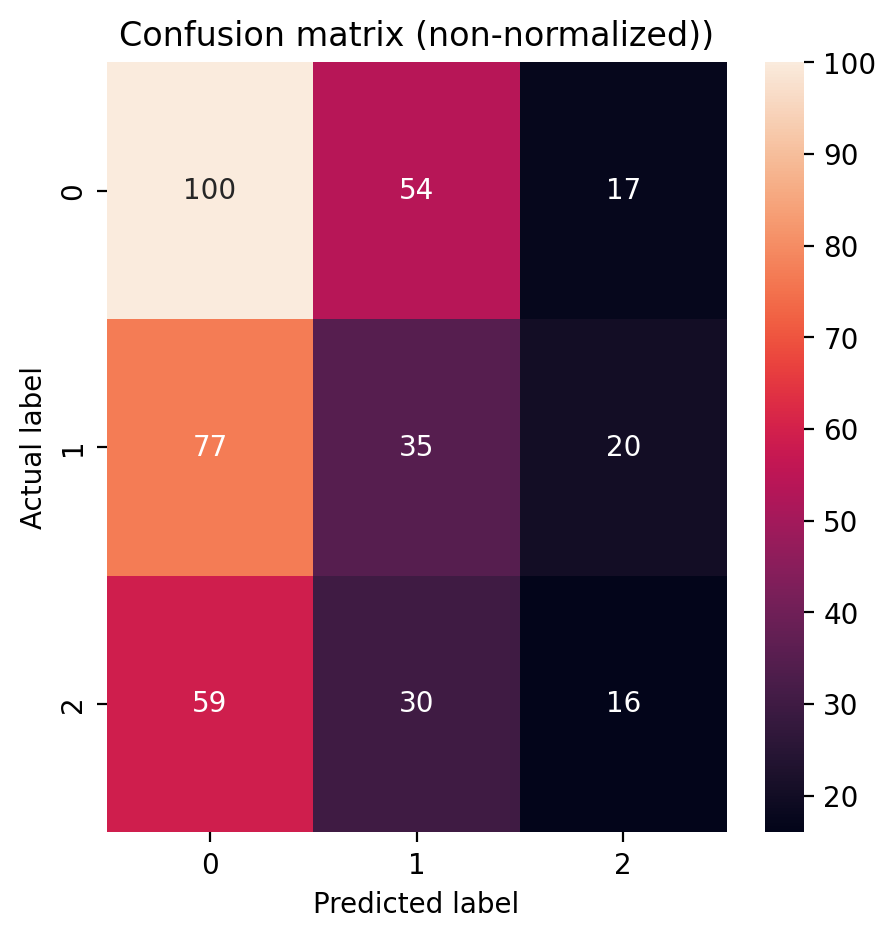

In [14]:
## very basic (without parameter optimization)
X_train = torch.stack(train_embeddings)  
y_train= torch.tensor(train_labels)
#y_train = nn.functional.one_hot(torch.tensor(train_labels), num_classes=num_classes).float()

X_test = torch.stack(test_embeddings)
y_test = torch.tensor(test_labels)

#train_model(MLPmodel, X_train, y_train, criterion, optimizer, num_epochs=epochs)
predictions = run_report_MLC(X_train, y_train, X_test, y_test)


In [15]:
output_path = '[your filename here].csv'
test_df['predictions'] = predictions
test_df.to_csv(output_path, index=False)

In [16]:
test_df

,id,example,term,pos,sense_id,definition,ANNOTATION,DEFICIENT SENTENCE,predictions
0,736,"""Bodie!... You cocksucker, you said it wouldn'...",cocksucker,noun,2,A very annoying or objectionable person.,1,NaN,0
1,2860,"... parasiting upon her husband, taking everyt...",parasite,verb,1,To parasitize.,2,NaN,2
2,2676,"Always an eloquent speaker, Polk became known ...",napoleon,noun,4,Clipping of Napoleon boot: a form of topboot w...,0,NaN,1
4,2171,"In his moronic book, _The Design Revolution: A...",IDiot,noun,1,A proponent of intelligent design.,1,NaN,0
5,1694,And you're scared and insecure and that's why ...,fudgebag,noun,1,A despicable or stupid person.,1,NaN,0
...,...,...,...,...,...,...,...,...,...
495,338,bourgeois opinion,bourgeois,adjective,1,"Of or relating to the middle class, (often der...",0,NaN,1
496,52,You know nothing about the law. You're a used-...,ambulance chaser,noun,1,An unethical attorney who solicits business at...,0,NaN,1
497,4371,When the troons speak about ‘gender neutral sp...,troon,noun,1,A transgender person.,0,NaN,1
498,3698,Her seven-year-old brother Justin sat on my la...,sissy,noun,4,Sister.,0,NaN,0
